# Face similarity

This project aims at finding the person the closest to the selected image.
It is based on siamese networks, [here](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf), and the dataset used for training is taken from [here](http://vis-www.cs.umass.edu/lfw/), the Labelled Faces in the Wild Home (LFW) Dataset. 

### Download the data

The data is accessible in this link, http://vis-www.cs.umass.edu/lfw/, and the dataset is here, http://vis-www.cs.umass.edu/lfw/lfw.tgz .

In [1]:
import os 
import requests
import shutil

# Download the data in the folder file
url = "http://vis-www.cs.umass.edu/lfw/lfw.tgz"
folder = "./data_faces"
target_path = os.path.join(folder,"faces.tgz")
face_folder = os.path.join(folder,"lfw")

if not os.path.exists(folder) :
    os.mkdir(folder)
    
    print("Downloading the data")
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(target_path, 'wb') as f:
            f.write(response.raw.read())
            
    # Unzip the downloaded data
    print("Unzipping the data")
    shutil.unpack_archive(target_path, folder)
    os.remove(target_path)

    # Only keep people with 4 images or more
    print("Removing persons with less than 4 images registered")

    for person in os.listdir(face_folder) :
        if len(os.listdir(os.path.join(face_folder,person))) < 4 :
            shutil.rmtree(os.path.join(face_folder,person), ignore_errors=False, onerror=None)
            
    print("There are {} different persons.".format(len(os.listdir(face_folder))))

### Preparing the data

We simply resize the images to 100x100 and visualize some examples.

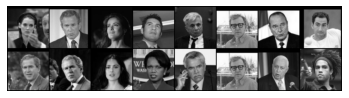

[1. 0. 0. 1. 1. 0. 1. 1.]


In [2]:
%matplotlib inline
from utils import *

# Load the training dataset
folder_dataset = datasets.ImageFolder(root=face_folder)

# Resize the images and transform to tensors
transformation = transforms.Compose([transforms.Resize((100,100)),
                                     transforms.ToTensor()
                                    ])

# Initialize the dataset
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transformation)

# Create a simple dataloader just for simple visualization
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=0,
                        batch_size=8)

# Extract one batch
example_batch = next(iter(vis_dataloader))

# Example batch is a list containing 2x8 images, indexes 0 and 1, an also the label
# If the label is 1, it means that it is not the same person, label is 0, same person in both images
concatenated = torch.cat((example_batch[0], example_batch[1]),0)

imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape(-1))

### Training parameters



In [3]:
batch_size = 64
lr = 0.0005
epochs = 1_000

In [4]:
# Load the training dataset
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=0,
                        batch_size=batch_size)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = SiameseNetwork().to(device)
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
print(f'Working on {device}')

Working on cpu


### Training

In [ ]:
from tqdm import tqdm

counter = []
loss_history = [] 
iteration_number= 0

# Iterate throught the epochs
pbar = tqdm(range(epochs))
for epoch in pbar:

    # Iterate over batches
    for i, (img0, img1, label) in enumerate(train_dataloader, 0):

        # Send the images and labels to device
        img0, img1, label = img0.to(device), img1.to(device), label.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Pass in the two images into the network and obtain two outputs
        output1, output2 = net(img0, img1)

        # Pass the outputs of the networks and label into the loss function
        loss_contrastive = criterion(output1, output2, label)

        # Calculate the backpropagation
        loss_contrastive.backward()

        # Optimize
        optimizer.step()
        
        # Display the loss
        pbar.set_postfix({
                "Epoch" : epoch,
                "Loss" : loss_contrastive.item()
            })

        # Every 10 batches print out the loss
        if i % 10 == 0 :
            # print(f"Epoch number {epoch}\n Current loss {loss_contrastive.item()}\n")
            iteration_number += 10

            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())

# Show the evolution of the loss
show_plot(counter, loss_history)

### Saving the network

Saves the network in a ```model``` directory.

In [ ]:
model_dir = "model"
model_file = "model.pth"

if not os.path.exists(model_dir) :
    os.mkdir(model_dir)

torch.save(net, os.path.join(model_dir, model_file))

### Load the model 

You can start at this point if you want to skip training.

In [5]:
model_dir = "model"
model_file = "model_1000.pth"

net = torch.load(os.path.join(model_dir, model_file),map_location=device)
net.eval()

SiameseNetwork(
  (cnn1): Sequential(
    (0): Conv2d(1, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU(inplace=True)
  )
  (fc1): Sequential(
    (0): Linear(in_features=384, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1024, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=2, bias=True)
  )
)

### Evaluation of the network

Need to download others data

In [13]:
!wget https://github.com/maticvl/dataHacker/raw/master/DATA/at%26t.zip
    
# unzip
test_directory = "./testing_faces"

if not os.path.exists(test_directory) :
    os.mkdir(test_directory)
    
import zipfile
with zipfile.ZipFile("at&t.zip", 'r') as zip_ref:
    zip_ref.extractall(test_directory)
os.remove("at&t.zip")

--2022-02-21 20:39:52--  https://github.com/maticvl/dataHacker/raw/master/DATA/at%26t.zip
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/maticvl/dataHacker/master/DATA/at%26t.zip [following]
--2022-02-21 20:39:52--  https://raw.githubusercontent.com/maticvl/dataHacker/master/DATA/at%26t.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3797060 (3.6M) [application/zip]
Saving to: 'at&t.zip.1'

     0K .......... .......... .......... .......... ..........  1% 1.48M 2s
    50K .......... .......... .......... .......... ..........  2% 13.3M 1s
   100K .......... .......... .......... ..........

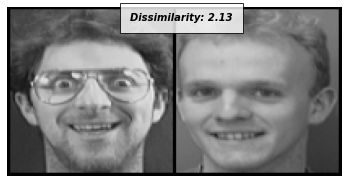

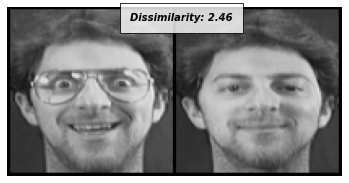

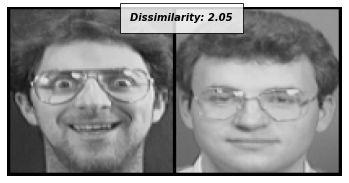

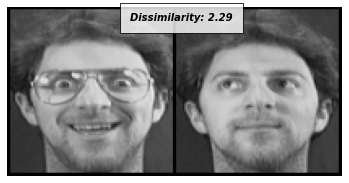

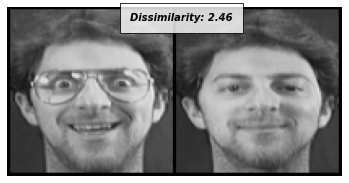

In [6]:
# Locate the test dataset and load it into the SiameseNetworkDataset
test_directory = "./testing_faces"
test_dir = os.path.join(test_directory,"data/faces/testing") # we use their training dataset as it is larger
folder_dataset_test = datasets.ImageFolder(root=test_dir)

# Create dataset test
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transformation)

# Create dataloader test
test_dataloader = DataLoader(siamese_dataset, num_workers=0, batch_size=1, shuffle=True)

# Grab one image that we are going to test
dataiter = iter(test_dataloader)
x0, _, _ = next(dataiter)

for i in range(5):
    # Iterate over 5 images and test them with the first image (x0)
    _, x1, label2 = next(dataiter)

    # Concatenate the two images together
    concatenated = torch.cat((x0, x1), 0)
    
    output1, output2 = net(x0.to(device), x1.to(device))
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euclidean_distance.item():.2f}')

### Perform prediction

Given an image you select in the prediction dataloader function, returns the most likely person given all the available in the selected *directory*.

In [8]:
# Resize the images and transform to tensors
transformation = transforms.Compose([transforms.Resize((100,100)),
                                     transforms.ToTensor()
                                    ])

directory = "./data_faces/lfw"
test_dataloader = create_dataset_testing(directory, transform=transformation)

file = "./photo.png"
prediction_dataloader = create_dataset_topredict(file,transform=transformation)

In [9]:
score, path = find_best_match(prediction_dataloader, test_dataloader, device, net)
path_final = "/".join(path)

100%|██████████| 1347/1347 [01:18<00:00, 17.11it/s]


### Show the results

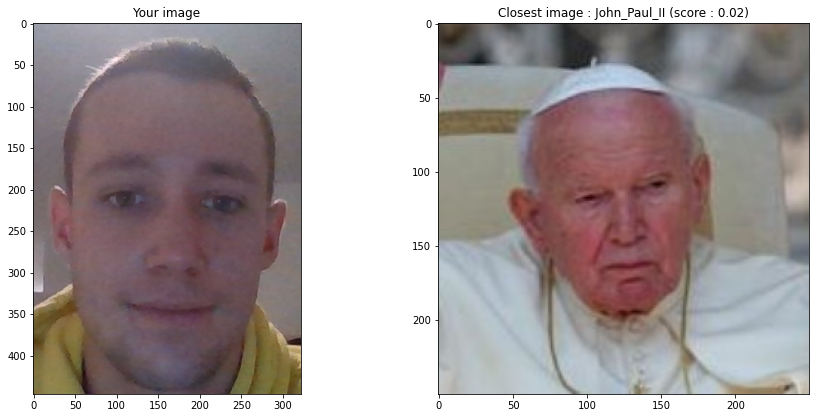

In [10]:
import matplotlib.pyplot as plt
from pathlib import Path

plt.figure(figsize=(15,15))

image_closest = np.array(Image.open(path_final))
name = Path(path_final).parts[-2]
plt.subplot(222)
plt.imshow(image_closest)
plt.title("Closest image : {} (score : {:.2f})".format(name,score))


your_image = np.array(Image.open(file))
plt.subplot(221)
plt.imshow(your_image)
plt.title("Your image")
plt.show()


### Heat map for all the images of a folder

In [19]:
folder_heat = os.path.join(test_directory,"data/faces/testing")
dataloader_full = create_dataset_testing(folder_heat, transform=transformation, batch_size=1)

# Create a filename to id dict
filename_to_id = {}
idx = 0
for folder in os.listdir(folder_heat) :
    for file in os.listdir(os.path.join(folder_heat,folder)) :
        filename_to_id[(folder,file)] = idx
        idx += 1

heat_map = np.zeros((len(dataloader_full), len(dataloader_full)))

for im1, cl1 in dataloader_full :
    for im2, cl2 in dataloader_full :
        im1, im2 = im1.to(device), im2.to(device)
        output1, output2 = net(im1,im2)
        euclidean_distance = F.pairwise_distance(output1, output2)
        idx1 = filename_to_id[(cl1[-2][0],cl1[-1][0])]
        idx2 = filename_to_id[(cl2[-2][0],cl2[-1][0])]
        heat_map[idx1,idx2] = euclidean_distance


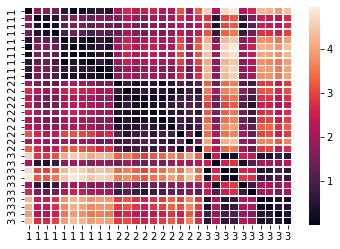

In [25]:
import seaborn as sns
labels = [1] * 10 + [2] * 10 + [3] * 10

ax = sns.heatmap(heat_map, linewidth=0.5,xticklabels=labels, yticklabels=labels)
plt.show()